# Fine-tuning con LoRA de F2LLM 4B — Entrada: text

## Importar librerías

In [1]:
import matplotlib.pyplot as plt
from torch import nn
import pandas as pd
import numpy as np
import torch
import json
import os

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    precision_recall_curve,
    roc_curve,
    auc
)

from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
from datasets import Dataset

from pyevall.evaluation import PyEvALLEvaluation
from pyevall.metrics.metricfactory import MetricFactory

## Configuración y parámetros

In [ ]:
os.environ["HF_TOKEN"] = ""

MODEL_NAME = "codefuse-ai/F2LLM-4B"
MAIN_PATH = ".."
GROUP_ID = "BeingChillingWeWillWin"
MODEL_ID = "f2llm4BText"

TEXT_COLUMN = "text"
LABEL_COLUMN = "label"

DATA_TRAIN_PATH = os.path.join(MAIN_PATH, "preprocessed_data", "train_split.json")
DATA_VAL_PATH   = os.path.join(MAIN_PATH, "preprocessed_data", "dev_split.json")
DATA_TEST_PATH  = os.path.join(MAIN_PATH, "preprocessed_data", "test_split.json")

OUTPUT_DIR      = os.path.join(MAIN_PATH, "weigths", f"F2LLM-4B_{TEXT_COLUMN}_lora")
SAVE_PATH       = os.path.join(MAIN_PATH, "weigths", f"F2LLM-4B_{TEXT_COLUMN}_final")
PREDICTIONS_DIR = os.path.join(MAIN_PATH, "predictions")

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PREDICTIONS_DIR, exist_ok=True)

## Carga y preprocesamiento de datos

In [3]:
def load_json_dataset(path):
    """Carga el JSON orientado a diccionario y devuelve un DataFrame."""
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return pd.DataFrame(data.values())

train_df = load_json_dataset(DATA_TRAIN_PATH)
val_df   = load_json_dataset(DATA_VAL_PATH)
test_df  = load_json_dataset(DATA_TEST_PATH)

label_map         = {"NO": 0, "YES": 1}
label_map_inverse = {0: "NO", 1: "YES"}

train_df["label_int"] = train_df[LABEL_COLUMN].map(label_map)
val_df["label_int"]   = val_df[LABEL_COLUMN].map(label_map)
test_df["label_int"]  = -1

print(f"Text column used : {TEXT_COLUMN}")
print(f"Train size: {len(train_df)} | Val size: {len(val_df)} | Test size: {len(test_df)}")
print(f"\nDistribución de etiquetas en TRAIN:")
print(train_df[LABEL_COLUMN].value_counts())
print(f"\nDistribución de etiquetas en VAL:")
print(val_df[LABEL_COLUMN].value_counts())

Text column used : text
Train size: 2146 | Val size: 537 | Test size: 687

Distribución de etiquetas en TRAIN:
label
YES    1282
NO      864
Name: count, dtype: int64

Distribución de etiquetas en VAL:
label
YES    321
NO     216
Name: count, dtype: int64


## Tokenización y preparación del dataset

In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def tokenize(batch):
    return tokenizer(
        batch[TEXT_COLUMN],
        truncation=True,
        padding="max_length",
        max_length=256
    )

train_dataset = Dataset.from_pandas(
    train_df[['id_EXIST', TEXT_COLUMN, 'label_int']].rename(columns={'label_int': 'label'})
).map(tokenize, batched=True)

eval_dataset = Dataset.from_pandas(
    val_df[['id_EXIST', TEXT_COLUMN, 'label_int']].rename(columns={'label_int': 'label'})
).map(tokenize, batched=True)

test_dataset = Dataset.from_pandas(
    test_df[['id_EXIST', TEXT_COLUMN, 'label_int']].rename(columns={'label_int': 'label'})
).map(tokenize, batched=True)

Map:   0%|          | 0/2146 [00:00<?, ? examples/s]

Map:   0%|          | 0/537 [00:00<?, ? examples/s]

Map:   0%|          | 0/687 [00:00<?, ? examples/s]

## Métricas de entrenamiento y configuración del modelo

In [5]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits_tensor = torch.tensor(logits).squeeze(-1)
    probs = torch.sigmoid(logits_tensor).numpy()
    preds = (probs >= 0.5).astype(int)

    if labels is None or (hasattr(labels, '__iter__') and any(l < 0 for l in labels)):
        return {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}


model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1,
    problem_type="single_label_classification"
)

if model.config.pad_token_id is None:
    model.config.pad_token_id = tokenizer.pad_token_id

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


class BinaryTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").float()
        outputs = model(**inputs)
        logits = outputs.logits.squeeze(-1)
        loss = nn.BCEWithLogitsLoss()(logits, labels)
        return (loss, outputs) if return_outputs else loss

Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

Qwen3ForSequenceClassification LOAD REPORT from: codefuse-ai/F2LLM-4B
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


trainable params: 5,900,800 || all params: 4,028,371,456 || trainable%: 0.1465


## Entrenamiento

In [6]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=5,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy="epoch",
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    bf16=True,
    lr_scheduler_type="cosine"
)

trainer = BinaryTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

model.save_pretrained(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.597494,0.677840,0.689744,0.838006,0.756681
2,0.638783,0.570687,0.716946,0.736695,0.819315,0.775811
3,0.638783,0.696181,0.720670,0.753709,0.791277,0.772036
4,0.200457,0.769159,0.724395,0.767802,0.772586,0.770186
5,0.200457,0.793133,0.715084,0.756098,0.772586,0.764253


('../weigths/F2LLM-4B_text_final/tokenizer_config.json',
 '../weigths/F2LLM-4B_text_final/chat_template.jinja',
 '../weigths/F2LLM-4B_text_final/tokenizer.json')

## Inferencia en DEV y cálculo del threshold óptimo (F1)

Mejor Threshold (DEV, max-F1): 0.4244
F1 en ese threshold           : 0.7904

Métricas en DEV con threshold óptimo (0.4244):
  Accuracy : 0.7225
  Precision: 0.7205
  Recall   : 0.8754
  F1-Score : 0.7904

AUC (DEV): 0.7775


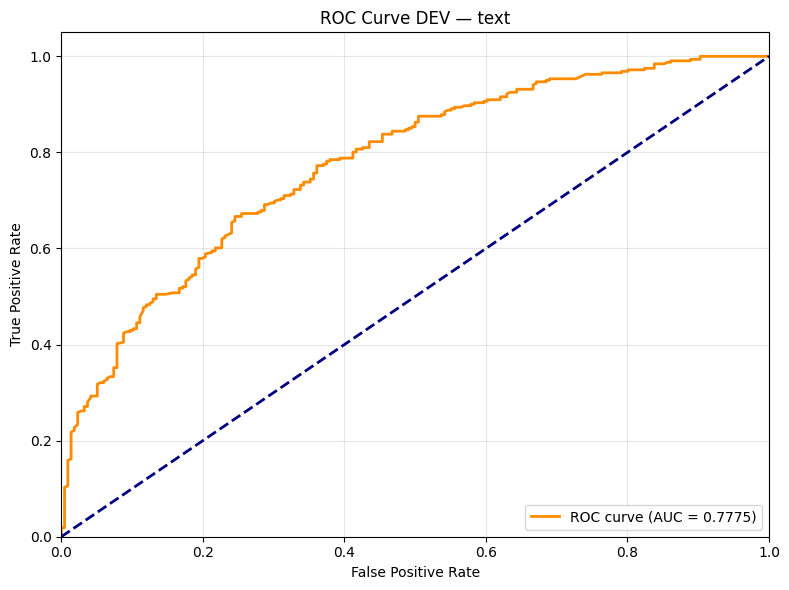

In [7]:
def save_probs_json(ids, probs, split_name, labels=None):
    records = []
    for i, (id_exist, prob) in enumerate(zip(ids, probs)):
        rec = {'id': str(id_exist), 'prob_YES': round(float(prob), 6)}
        if labels is not None:
            rec['label'] = label_map_inverse[int(labels[i])]
        records.append(rec)
    path = os.path.join(PREDICTIONS_DIR, f'{GROUP_ID}_{MODEL_ID}_probs_{split_name}.json')
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(records, f, ensure_ascii=False, indent=2)
    

dev_predictions = trainer.predict(eval_dataset)

dev_logits   = torch.tensor(dev_predictions.predictions).squeeze(-1)
y_probs_dev  = torch.sigmoid(dev_logits).numpy()
y_true_dev   = dev_predictions.label_ids

precisions, recalls, thresholds = precision_recall_curve(y_true_dev, y_probs_dev)
f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-10)
optimal_idx       = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Mejor Threshold (DEV, max-F1): {optimal_threshold:.4f}")
print(f"F1 en ese threshold           : {f1_scores[optimal_idx]:.4f}")

dev_preds_optimal = (y_probs_dev >= optimal_threshold).astype(int)
precision_opt, recall_opt, f1_opt, _ = precision_recall_fscore_support(
    y_true_dev, dev_preds_optimal, average='binary', zero_division=0
)
acc_opt = accuracy_score(y_true_dev, dev_preds_optimal)

save_probs_json(val_df['id_EXIST'].values, y_probs_dev, 'dev', labels=val_df['label_int'].values)

print(f"\nMétricas en DEV con threshold óptimo ({optimal_threshold:.4f}):")
print(f"  Accuracy : {acc_opt:.4f}")
print(f"  Precision: {precision_opt:.4f}")
print(f"  Recall   : {recall_opt:.4f}")
print(f"  F1-Score : {f1_opt:.4f}")

fpr, tpr, _ = roc_curve(y_true_dev, y_probs_dev)
roc_auc = auc(fpr, tpr)

print(f"\nAUC (DEV): {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve DEV — {TEXT_COLUMN}')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Evaluación en DEV con PyEvALL

In [8]:
dev_preds_for_pyevall = [
    {'test_case': 'EXIST2025', 'id': str(id_exist), 'value': label_map_inverse[pred]}
    for id_exist, pred in zip(val_df['id_EXIST'].values, dev_preds_optimal)
]
dev_preds_df   = pd.DataFrame(dev_preds_for_pyevall)
dev_preds_path = os.path.join(PREDICTIONS_DIR, 'dev_predictions_temp.json')
with open(dev_preds_path, 'w', encoding='utf-8') as f:
    f.write(dev_preds_df.to_json(orient='records'))

dev_gold = [
    {'test_case': 'EXIST2025', 'id': str(id_exist), 'value': label}
    for id_exist, label in zip(val_df['id_EXIST'].values, val_df[LABEL_COLUMN].values)
]
dev_gold_df   = pd.DataFrame(dev_gold)
dev_gold_path = os.path.join(PREDICTIONS_DIR, 'dev_gold_temp.json')
with open(dev_gold_path, 'w', encoding='utf-8') as f:
    f.write(dev_gold_df.to_json(orient='records'))

test_eval = PyEvALLEvaluation()
metrics   = [MetricFactory.Accuracy.value, MetricFactory.FMeasure.value]
report    = test_eval.evaluate(dev_preds_path, dev_gold_path, metrics)
print("\n=== Evaluación en DEV con PyEvALL ===")
report.print_report()

2026-02-28 23:22:16,328 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['Accuracy', 'FMeasure']


2026-02-28 23:22:16,361 - pyevall.metrics.metrics - INFO -             evaluate() - Executing accuracy evaluation method


2026-02-28 23:22:16,422 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method



=== Evaluación en DEV con PyEvALL ===
{
  "metrics": {
    "Accuracy": {
      "name": "Accuracy",
      "acronym": "Acc",
      "description": "Coming soon!",
      "status": "OK",
      "results": {
        "test_cases": [{
          "name": "EXIST2025",
          "average": 0.7225325884543762
        }],
        "average_per_test_case": 0.7225325884543762
      }
    },
    "FMeasure": {
      "name": "F-Measure",
      "acronym": "F1",
      "description": "Coming soon!",
      "status": "OK",
      "results": {
        "test_cases": [{
          "name": "EXIST2025",
          "classes": {
            "YES": 0.790436005625879,
            "NO": 0.5895316804407713
          },
          "average": 0.6899838430333252
        }],
        "average_per_test_case": 0.6899838430333252
      }
    }
  },
  "files": {
    "dev_predictions_temp.json": {
      "name": "dev_predictions_temp.json",
      "status": "OK",
      "gold": false,
      "description": "Use parameter: report=\"embedde

## Inferencia en TEST y generación de predicciones finales

In [9]:
test_predictions = trainer.predict(test_dataset)

test_logits  = torch.tensor(test_predictions.predictions).squeeze(-1)
y_probs_test = torch.sigmoid(test_logits).numpy()
test_preds   = (y_probs_test >= optimal_threshold).astype(int)

save_probs_json(test_df['id_EXIST'].values, y_probs_test, 'test')

print(f"\nPredicciones en TEST (threshold={optimal_threshold:.4f}):")
print(f"  Total   : {len(test_preds)}")
print(f"  YES     : {np.sum(test_preds == 1)} ({100*np.mean(test_preds == 1):.2f}%)")
print(f"  NO      : {np.sum(test_preds == 0)} ({100*np.mean(test_preds == 0):.2f}%)")


Predicciones en TEST (threshold=0.4244):
  Total   : 687
  YES     : 518 (75.40%)
  NO      : 169 (24.60%)


## Guardar predicciones en formato PyEvALL para TEST

In [10]:
test_preds_for_submission = [
    {'test_case': 'EXIST2025', 'id': str(id_exist), 'value': label_map_inverse[pred]}
    for id_exist, pred in zip(test_df['id_EXIST'].values, test_preds)
]
test_preds_df = pd.DataFrame(test_preds_for_submission)

output_filename = f"{GROUP_ID}_{MODEL_ID}.json"
output_path     = os.path.join(PREDICTIONS_DIR, output_filename)

with open(output_path, 'w', encoding='utf-8') as f:
    f.write(test_preds_df.to_json(orient='records'))

print(f"\nPredicciones guardadas en: {output_path}")


Predicciones guardadas en: ../predictions/BeingChillingWeWillWin_f2llm4BText.json
